In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data import Dataset

In [3]:
class time_series_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,N=4500,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.N = N
        self.transform = None
        
        # time points
        self.x = torch.cat(N*[torch.arange(0,t0+24).type(torch.float).unsqueeze(0)])

        # sinuisoidal signal
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)        
        self.fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*self.x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*self.x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*self.x[0,24:t0]/6)+72,
                        A4.unsqueeze(1)*torch.sin(np.pi*self.x[0,t0:t0+24]/12)+72],1)
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {"x":self.x[idx,0:t0],
                  "x_next":self.x[idx,:t0:t0+24],
                  "fx": self.fx[idx,0:t0],
                  "fx_next":self.fx[idx,0:t0+24]}
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample

In [4]:
t0 = 96
N = 100

In [5]:
dataset = time_series_paper(t0,N)

x: 100*120 fx: 100*120


In [6]:
dataset.fx

tensor([[ 72.0000,  98.1672, 117.3229,  ...,  34.9940,  45.8328,  58.4550],
        [ 72.0000,  99.0903, 118.9218,  ...,  33.6885,  44.9097,  57.9771],
        [ 72.0000,  81.7612,  88.9070,  ...,  42.2312,  50.9503,  61.1039],
        ...,
        [ 72.0000,  90.3159, 103.7241,  ...,  42.8382,  51.3795,  61.3261],
        [ 72.0000,  73.0570,  73.8308,  ...,  54.9721,  59.9594,  65.7674],
        [ 72.0000,  93.3357, 108.9544,  ...,  35.7390,  46.3596,  58.7276]])

In [8]:
dataset.x

tensor([[  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        ...,
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.],
        [  0.,   1.,   2.,  ..., 117., 118., 119.]])

In [11]:
dataset[0]

{'x': tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
         56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
         70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
         84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.]),
 'x_next': tensor([0.]),
 'fx': tensor([ 72.0000,  98.1672, 117.3229, 124.3344, 117.3229,  98.1672,  72.0000,
          45.8328,  26.6771,  19.6656,  26.6771,  45.8328,  72.0000,  81.9719,
          89.2718,  91.9437,  89.2718,  81.9719,  72.0000,  62.0281,  54.7282,
          52.0563,  54.7282,  62.0281,  72.0000,  93.3866, 109.0427, 114.7732,
         109.0426,  93.3866,  72.0000,  50.6134,  34.9573,  29.2268,  34.9573,
          50.6134,  72.0

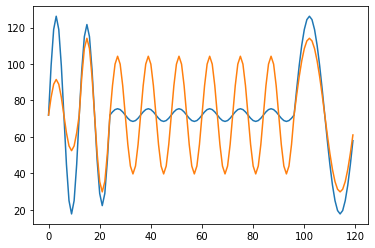

In [12]:
plt.plot(dataset.x[1].numpy(),dataset.fx[1].numpy())
plt.plot(dataset.x[2].numpy(),dataset.fx[2].numpy())
plt.show()